In [19]:
!ls

'ls' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


# First steps using mne


## Imports

In [7]:
# std
import os
from os import path
import time

# 3p
import mne
import numpy as np
import matplotlib.pyplot as plt

# prj
os.chdir("..")
from src import helpers
os.chdir('analysis-adelie')

%matplotlib inline

## Config

In [8]:
# This is the config. Add any value that you deem necessary. This should contain everything that belongs to the setup, 
# the filtering pipeline, etc.

cfg = {
    'paths': {
        'base': '../../data/AlphaTheta',
        'subjects': {
            'sam': {
                'prefix'
                : '/sam-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                },
                'channels_path': 'channelsList.txt'
            },
            'adelie': {
                'prefix': '/adelie-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-151358',
                    ],
                    'meditation': [
                        '20200311-104132',
                    ]
                },
                'channels_path': 'channelsList.txt'
            }
        }
    },
    'columns_to_remove': [
        'TRIGGER', 'X1', 'X2', 'X3',
    ],
    'default_signal_crop': np.s_[3000:-3000], # this corresponds to ~1 second at the beginning and end, given by the sampling frequency
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [1, 4]
    }
}

## Base I/O


In [9]:
baseline_adelie_pd = helpers.load_signal_data('baseline', subject='adelie', config=cfg)
meditation_adelie_pd = helpers.load_signal_data('meditation', subject='adelie', config=cfg)

In [51]:
electrode_of_interest = 'A2'

In [52]:
start = time.time()
bandpower_adelie = {
    'baseline': helpers.get_bandpower_for_electrode(baseline_adelie_pd, electrode=electrode_of_interest, config=cfg),
    'meditation': helpers.get_bandpower_for_electrode(meditation_adelie_pd, electrode=electrode_of_interest, config=cfg)
}
end = time.time()
print("Took {}s to compute bandpower for electrode {}".format(end-start, electrode_of_interest))

Took 193.60101532936096s to compute bandpower for electrode A2


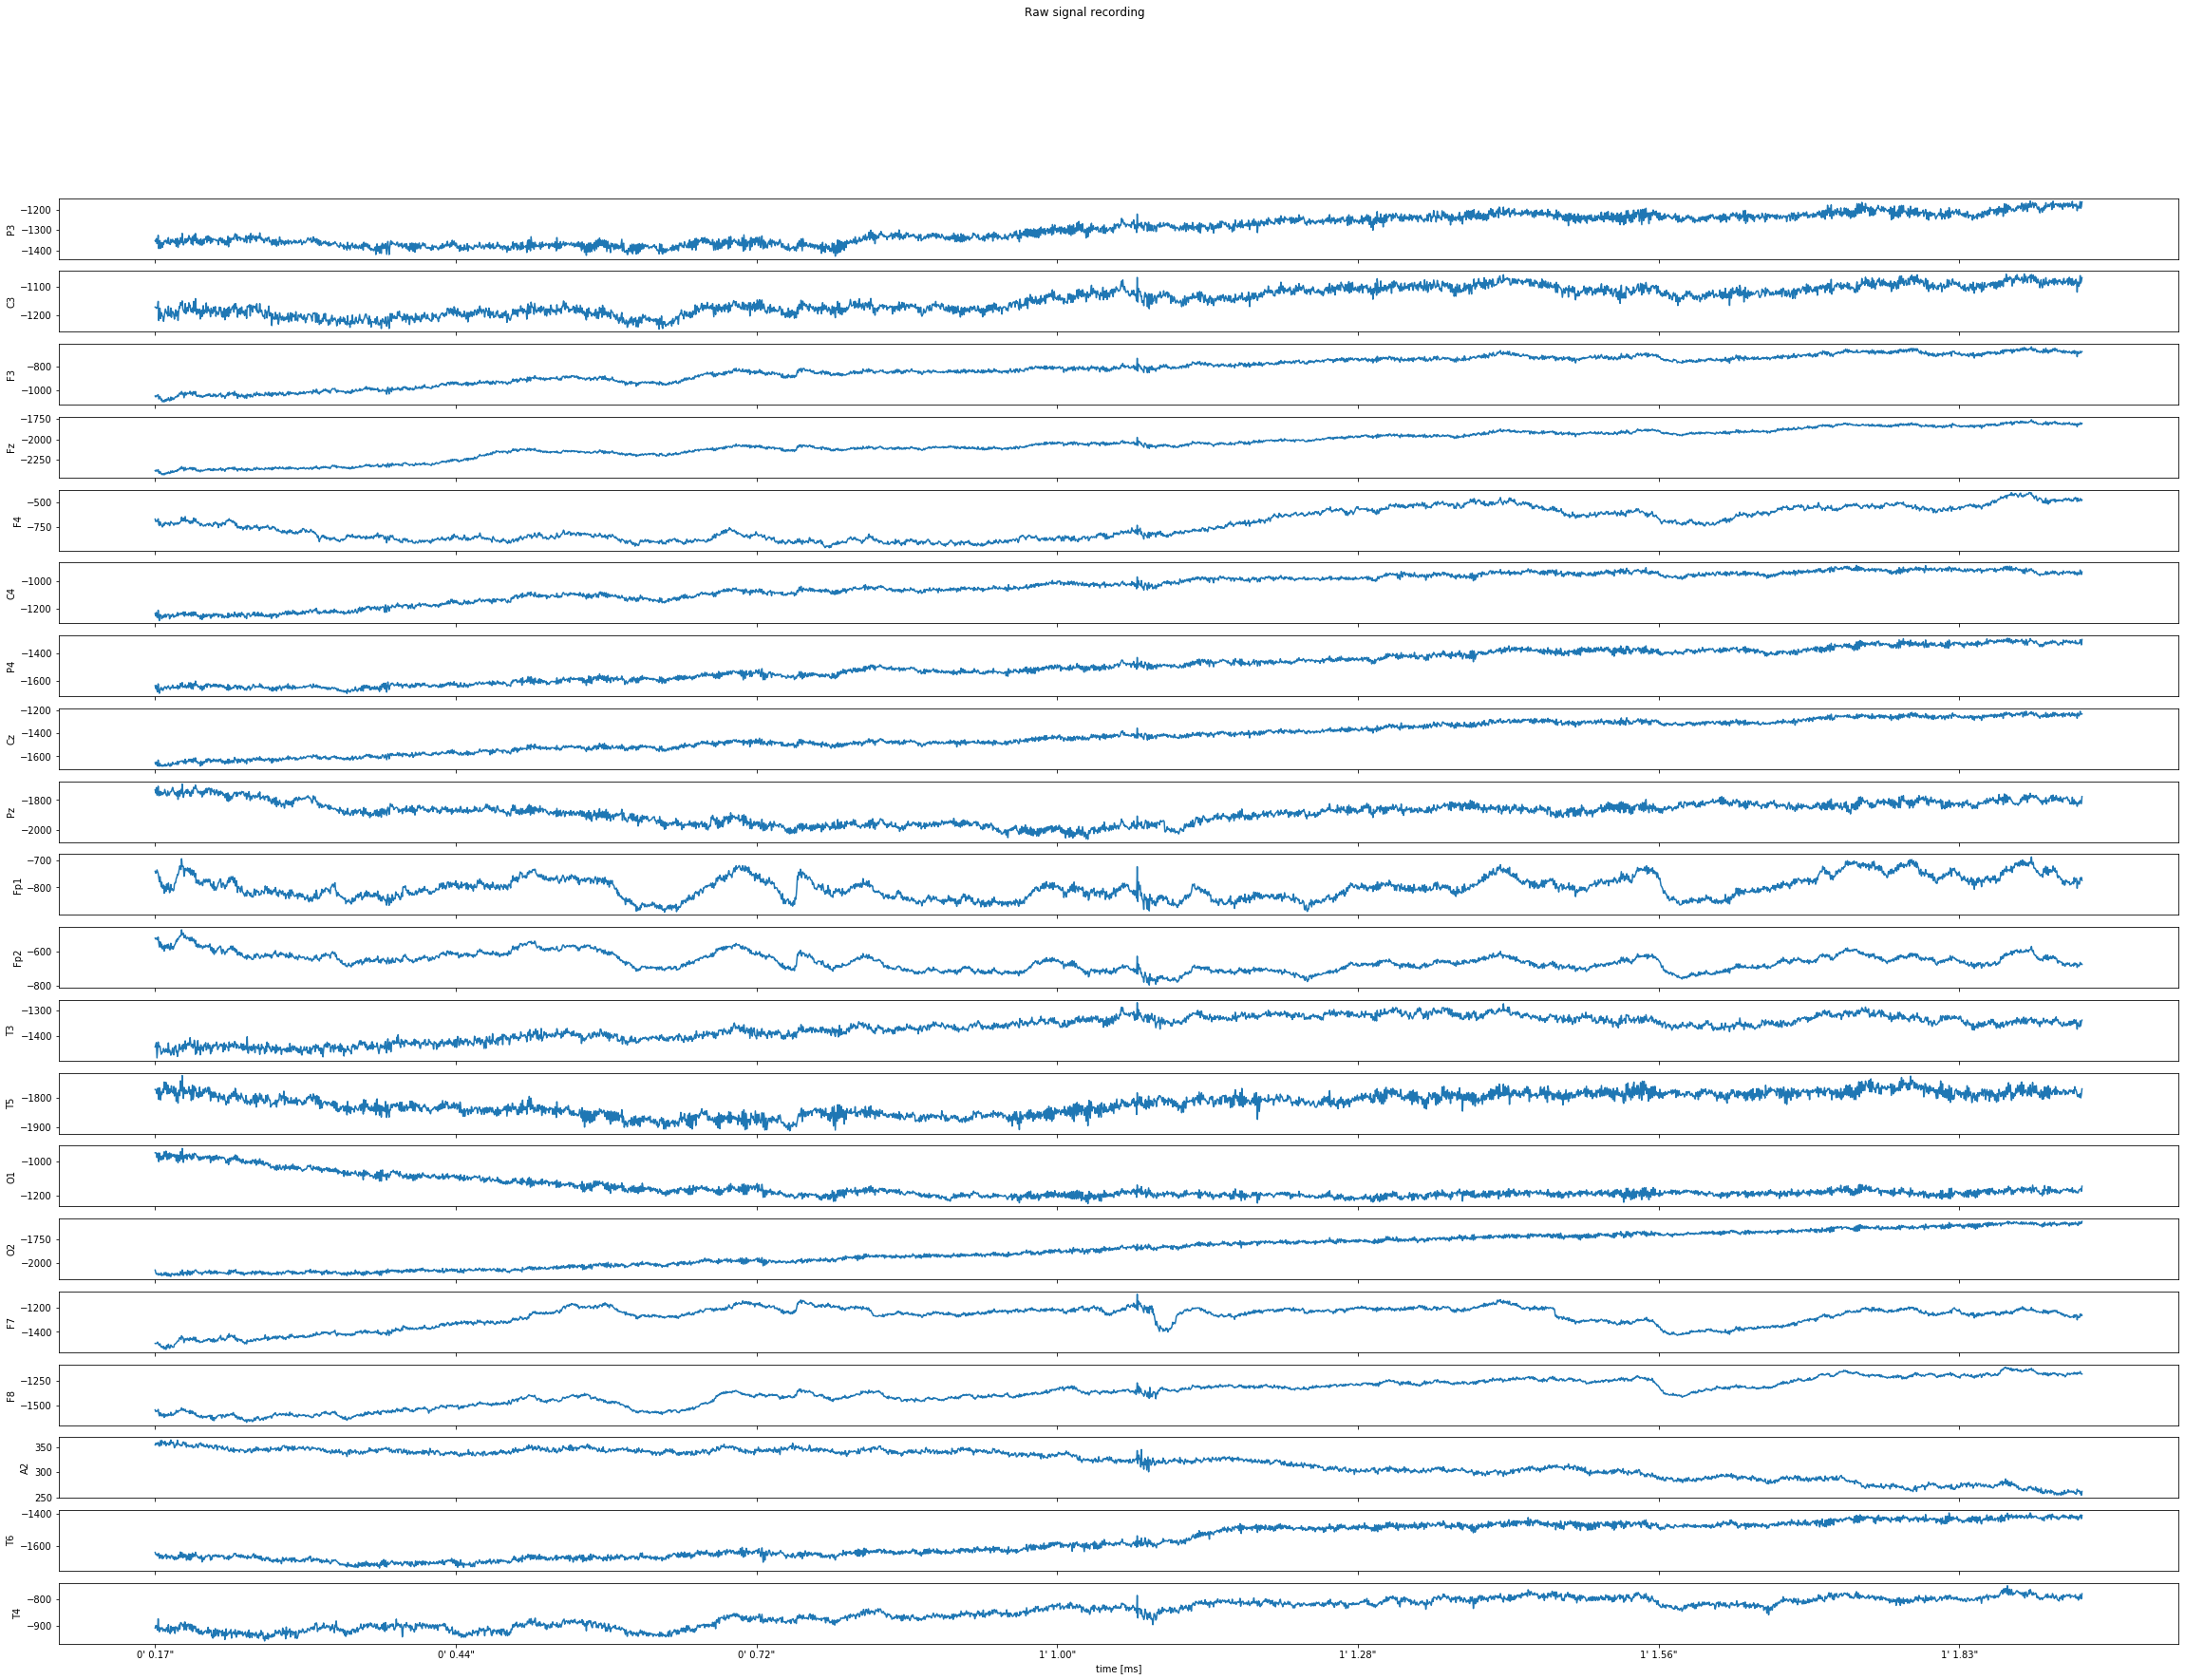

In [6]:
helpers.plot_raw_signal(baseline_adelie_pd);

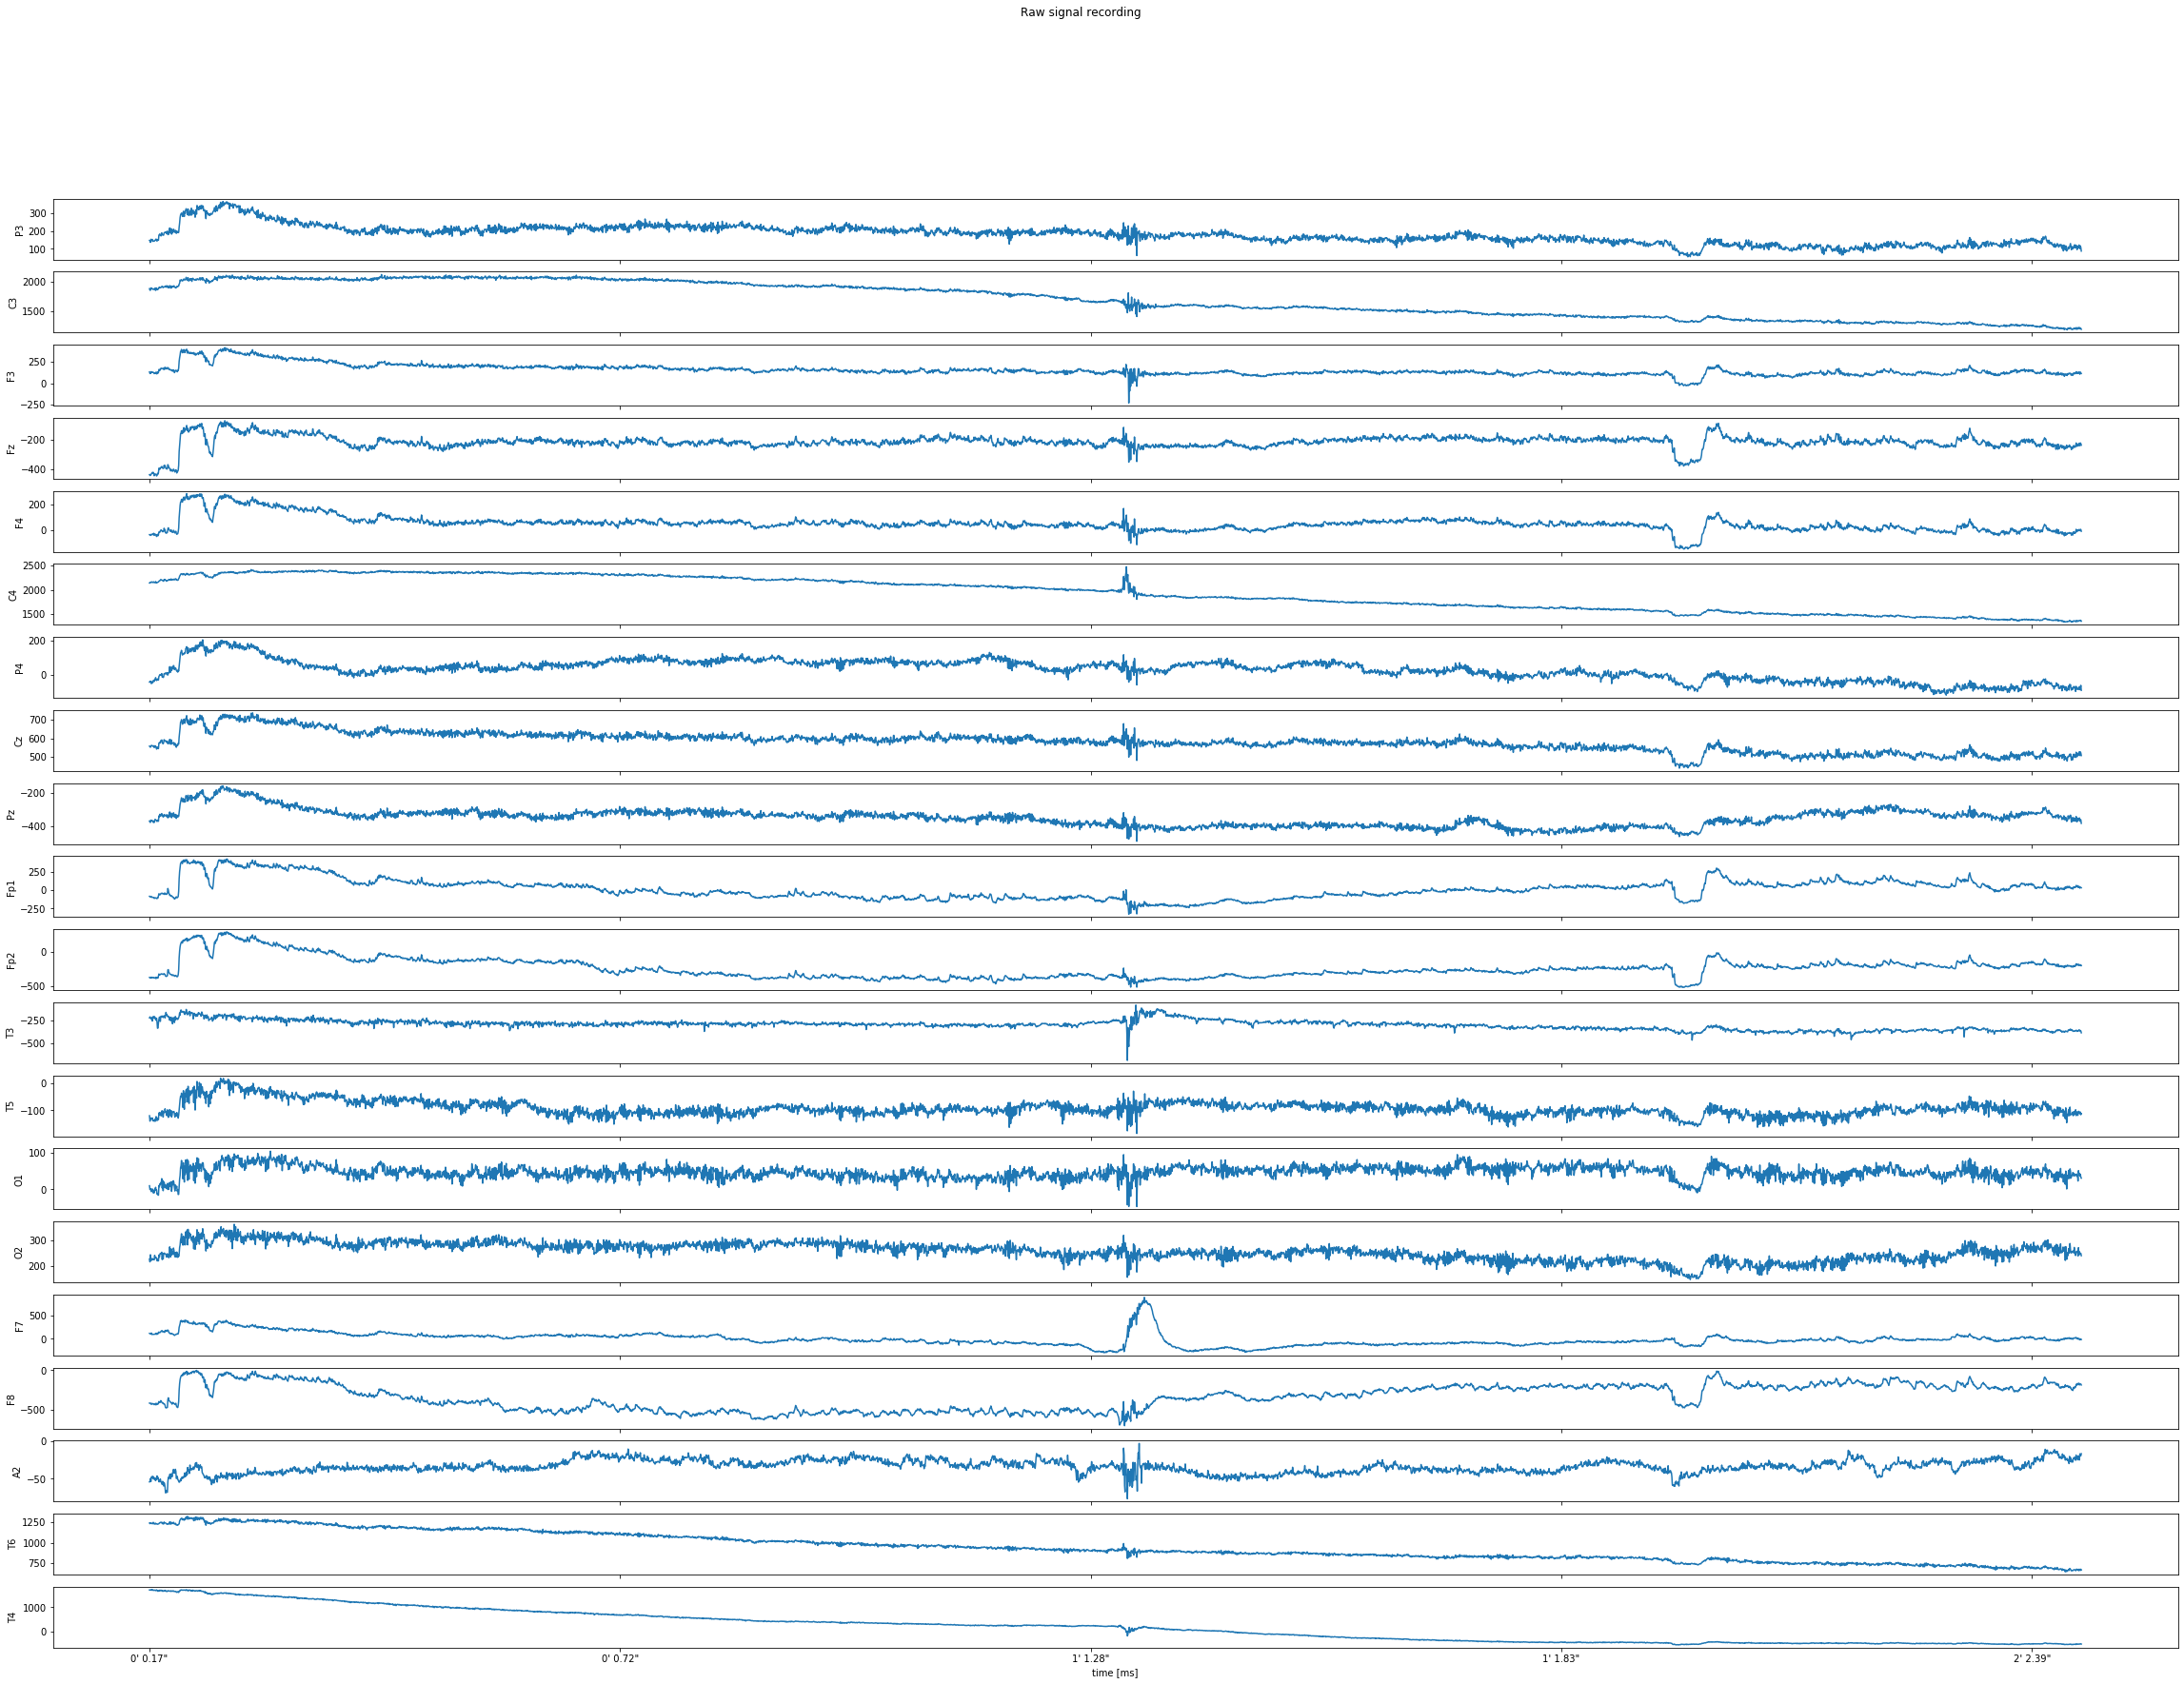

In [7]:
helpers.plot_raw_signal(meditation_adelie_pd);

In [8]:
aggregated_power_adelie = helpers.aggregate_bandpower(baseline=bandpower_adelie['baseline'], signal=bandpower_adelie['meditation'])
aggregated_power_adelie

mean    median        min      max
gamma         baseline     8.58954   6.97805    3.89778  93.8201
              meditation    11.177   7.11231    3.16088  449.006
beta          baseline     10.5799   10.0346    4.20081  34.9405
              meditation   9.96974   8.68338    2.58147  112.873
alpha         baseline     41.2142   33.7936    6.02974  167.974
              meditation   42.1417   31.3672    2.80388  230.712
theta         baseline     20.3188   16.8603    1.67143   123.73
              meditation    17.823   14.8385    1.50278  144.695
delta         baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
gamma / beta  baseline    0.802605   0.72379   0.337866   3.9874
              meditation  0.976687  0.829274    0.30698  9.85409
gamma / alpha baseline    0.299301  0.210973  0.0454615   5.2537
              meditation  0.383935   0.23748  0.0310863   5.7118
gamma / theta baseline     0.59782  0.427338  0.0675693  5.76874
              meditation  0.752042  0.495011  0.0761694  16.7679
gamma / delta baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
beta / alpha  baseline     0.33902  0.282701  0.0556308  1.81598
              meditation  0.341422  0.277461  0.0641981  2.11076
beta / theta  baseline    0.714392  0.595351   0.101674  6.97054
              meditation  0.697567  0.595982  0.0882295  11.8185
beta / delta  baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
alpha / theta baseline     2.35703   2.11442    0.29637  23.7001
              meditation   2.54048   2.15259   0.201284    56.77
alpha / delta baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN
theta / delta baseline         NaN       NaN        NaN      NaN
              meditation       NaN       NaN        NaN      NaN

## Helpers

In [10]:
def get_channelsList(config, subject='adelie'):
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    file_path = f"{base_path}/{subject_paths['prefix']}/offline/fif/{subject_paths['channels_path']}"
    with open(file_path, 'r') as channels_file:
        all_channels = channels_file.read().strip()
    return [channel for channel in all_channels.split('\n') if channel not in config['columns_to_remove']]

events = None
def load_raw_mne_from_fif(data_type, subject='adelie', recording=0, montage='standard_1020', config=cfg):
    global events
    """loads the data and returns an instance of mne.Raw
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
    montage: string
      the type of montage that was used for the recording see: https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
      
    Returns
    -------
    a mne.Raw instance that has the correct montage and info and is ready to be plotted
    """
    subject_paths = helpers.get_config_value(config, 'paths', 'subjects', subject)
    base_path = helpers.get_config_value(config, 'paths', 'base')
    recording_id = helpers.get_config_value(subject_paths, 'recordings', data_type)[recording]
    file_path = f"{base_path}{subject_paths['prefix']}/offline/fif/{recording_id}-raw.fif"
    
    # Create a digitization of the montage
    digitization = mne.channels.make_standard_montage(montage)
    channels = get_channelsList(config, subject=subject)
    
    # Read from fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    events = mne.find_events(raw)

    
    # Create info with some useful information
    info = mne.create_info(get_channelsList(config), sfreq=config['sampling_frequency'], ch_types='eeg')
    raw.info = info
    
    # set the montage
    raw.set_montage(digitization)
    
    raw = raw.pick_types(eeg=True, stim=True)
    raw.set_eeg_reference('average', projection=True)#.apply_proj()
    
    return raw

## Some interesting plots of raw data and CSD data

In [11]:
baseline_adelie_mne = load_raw_mne_from_fif('baseline', montage='standard_1020')
baseline_adelie_csd = mne.preprocessing.compute_current_source_density(baseline_adelie_mne)

Opening raw data file ../../data/AlphaTheta/adelie-AlphaTheta/offline/fif/20200304-151358-raw.fif...
Isotrak not found
    Range : 0 ... 38041 =      0.000 ...   126.803 secs
Ready.
Reading 0 ... 38041  =      0.000 ...   126.803 secs...
2 events found
Event IDs: [15 16]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


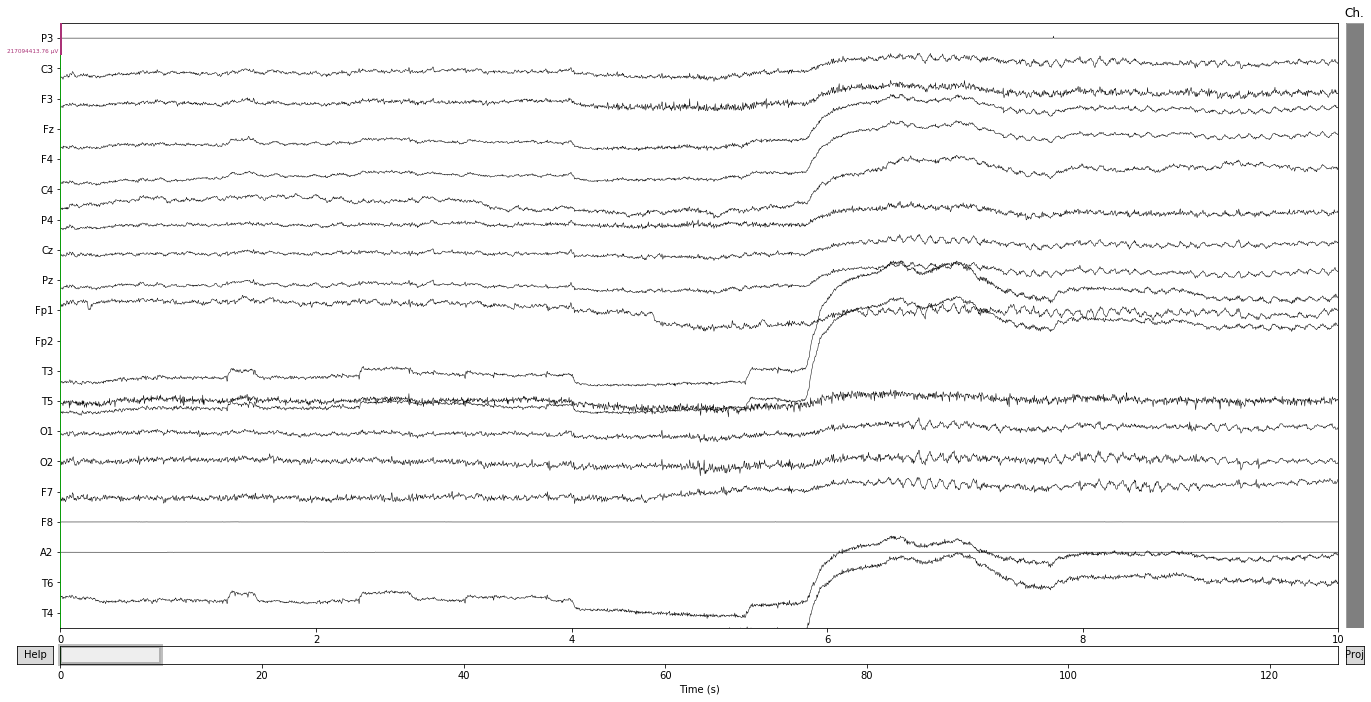

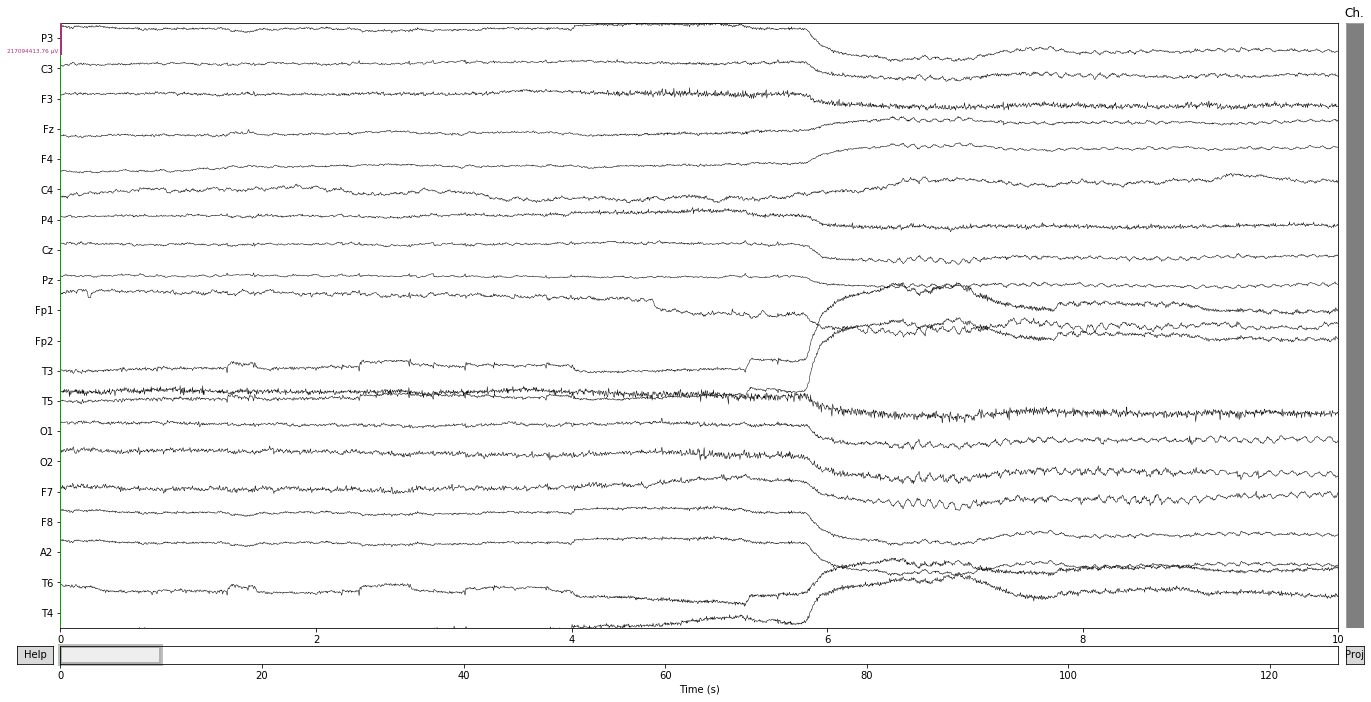

In [16]:
for title, proj in zip(['Original', 'Average'], [False, True]):
    fig = baseline_adelie_mne.plot(proj=proj, n_channels=len(baseline_adelie_mne), scalings='auto')
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

In [50]:
for title, proj in zip(['Original', 'Average'], [False, True]):
    fig = baseline_adelie_csd.plot_psd(proj=proj)
    # make room for title
    fig.subplots_adjust(top=0.9)
    fig.suptitle('{} reference'.format(title), size='xx-large', weight='bold')

Effective window size : 6.827 (s)


Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Effective window size : 6.827 (s)


In [13]:
meditation_adelie_mne = load_raw_mne_from_fif('meditation')
meditation_adelie_csd = mne.preprocessing.compute_current_source_density(meditation_adelie_mne)

Opening raw data file ../../data/AlphaTheta/adelie-AlphaTheta/offline/fif/20200311-104132-raw.fif...
Isotrak not found
    Range : 0 ... 47051 =      0.000 ...   156.837 secs
Ready.
Reading 0 ... 47051  =      0.000 ...   156.837 secs...
1 events found
Event IDs: [16]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


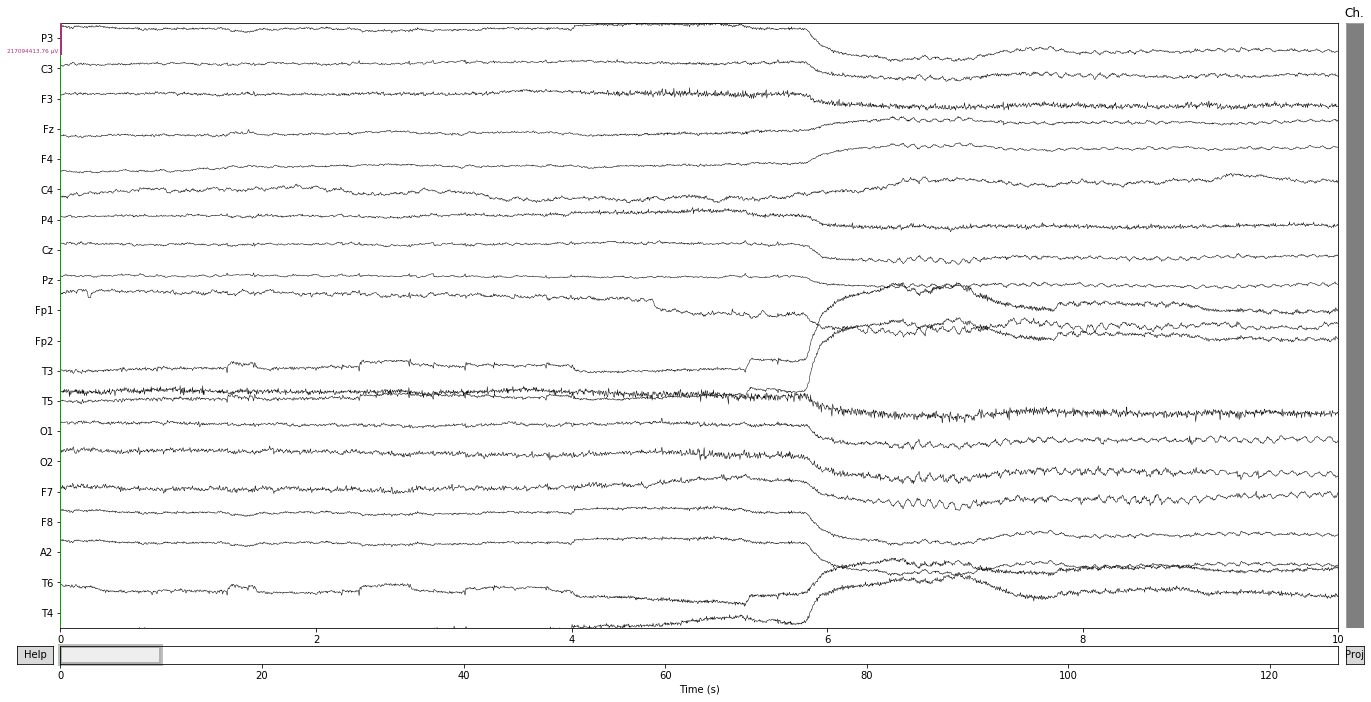

Effective window size : 6.827 (s)


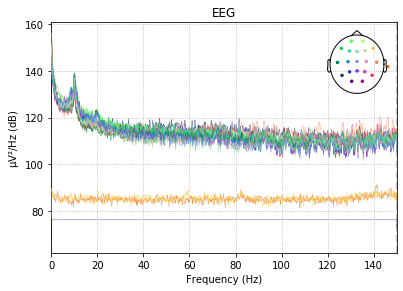

In [14]:
baseline_adelie_mne.plot(scalings='auto');
baseline_adelie_mne.plot_psd();

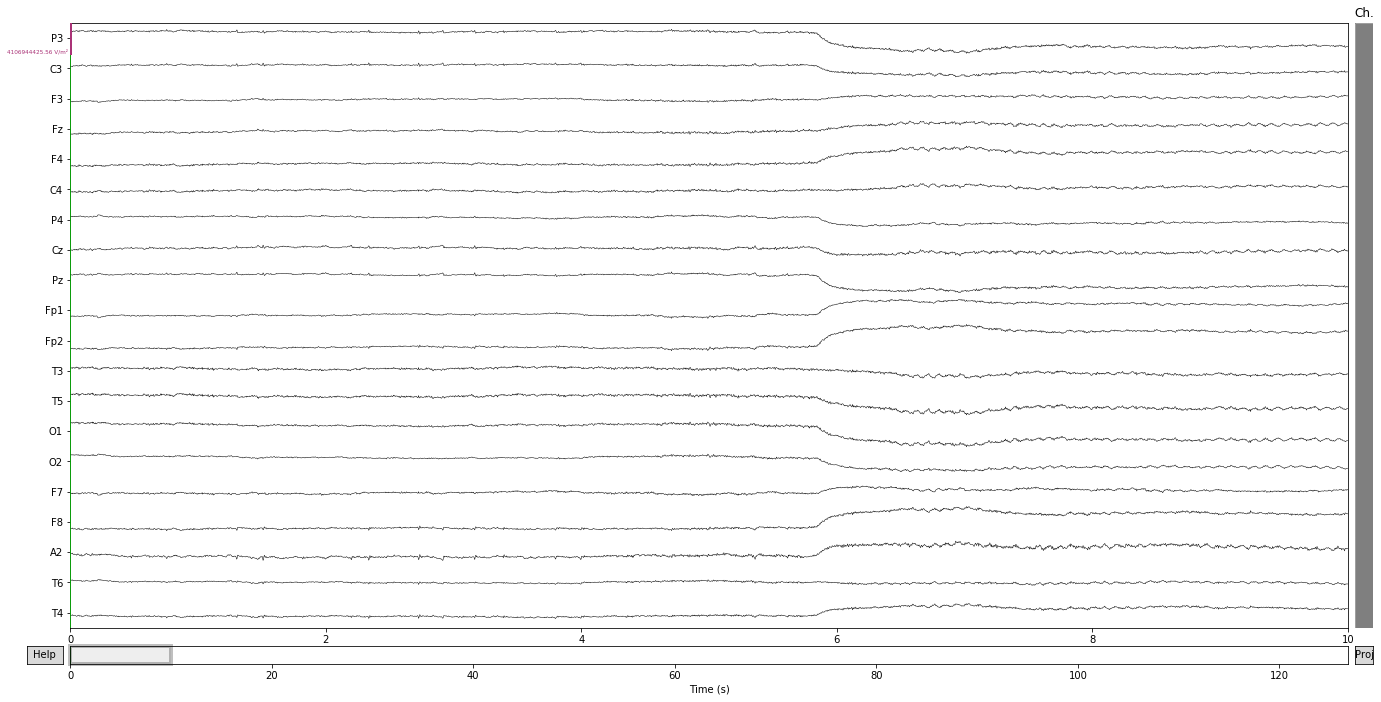

Effective window size : 6.827 (s)


In [18]:
baseline_adelie_csd.plot(scalings='auto');
baseline_adelie_csd.plot_psd();

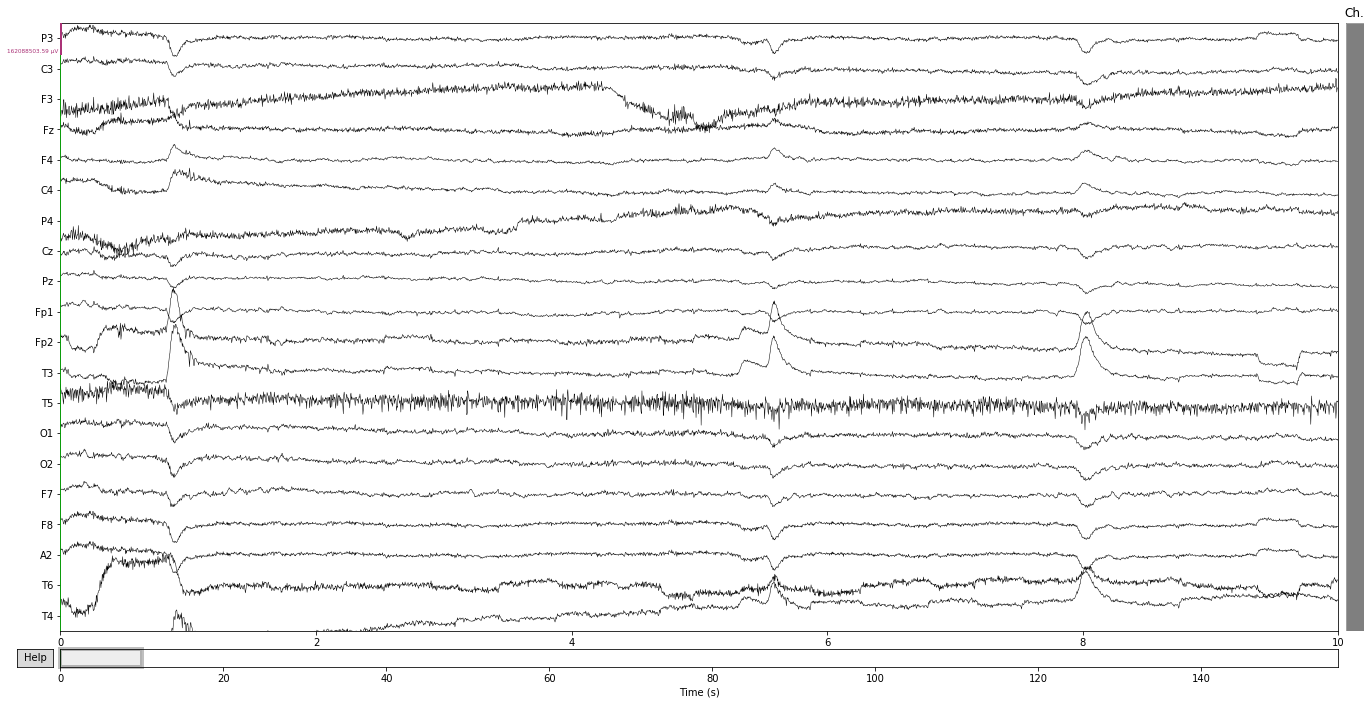

Effective window size : 6.827 (s)


In [74]:
meditation_adelie_mne.plot(scalings='auto');
meditation_adelie_mne.plot_psd();

In [75]:
meditation_adelie_csd.plot(scalings='auto');
meditation_adelie_csd.plot_psd();

Effective window size : 6.827 (s)


## Taking a look at events

In [16]:
baseline_adelie_mne.stim_channel = 'TRIGGER'

event_id = {
    "END": 16
}


epochs = mne.Epochs(baseline_adelie_mne, events, event_id=event_id, tmin=-0.2, tmax=.5,
                    preload=True)
evoked = epochs['END'].average()

1 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 1 events and 211 original time points ...
1 bad epochs dropped


C:\Users\adeli\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\adeli\Anaconda3\lib\site-packages\numpy\core\_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
<ipython-input-16-3c52cf301ef5>:10: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  evoked = epochs['END'].average()


Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


C:\Users\adeli\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:77: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
C:\Users\adeli\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:78: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)


ValueError: Some of the values  to be plotted are NaN.

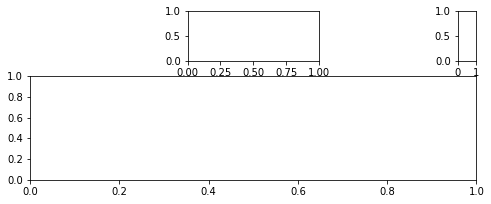

In [17]:
times = np.array([-0.1, 0., 0.05, 0.1, 0.15])
evoked_csd = mne.preprocessing.compute_current_source_density(evoked)
evoked.plot_joint(title='Average Reference', show=False)
evoked_csd.plot_joint(title='Current Source Density')

Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin

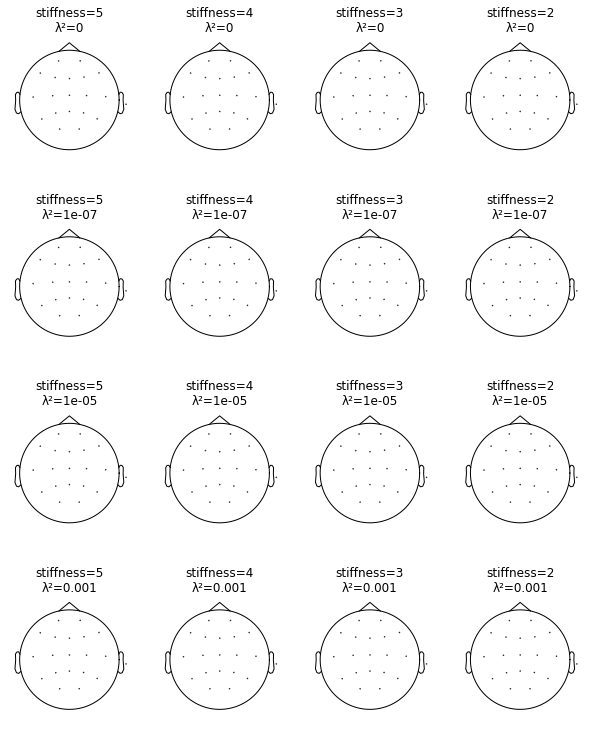

In [18]:
fig, ax = plt.subplots(4, 4)
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 10)
for i, lambda2 in enumerate([0, 1e-7, 1e-5, 1e-3]):
    for j, m in enumerate([5, 4, 3, 2]):
        this_evoked_csd = mne.preprocessing.compute_current_source_density(
            evoked, stiffness=m, lambda2=lambda2)
        this_evoked_csd.plot_topomap(
            0.1, axes=ax[i, j], outlines='skirt', contours=4, time_unit='s',
            colorbar=False, show=False)
        ax[i, j].set_title('stiffness=%i\nλ²=%s' % (m, lambda2))

## For reference only

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
Creating RawArray with float64 data, n_channels=90, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


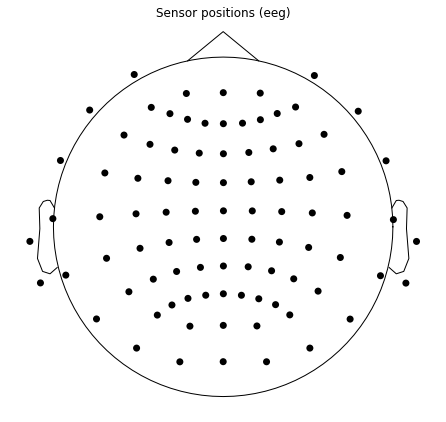

In [27]:
fig = dig.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
dig.plot(kind='topomap', show_names=False);

In [26]:
dig = mne.channels.make_standard_montage('standard_1020')
channels = ['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Pz', 'Fp1', 'Fp2','T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'A2', 'T6', 'T4']
adelie_info = mne.create_info(list(meditation_adelie_pd.columns.values), 300, ch_types='eeg')
meditation_adelie_mne = mne.io.RawArray(meditation_adelie_pd.values.transpose()/1000000, adelie_info)
meditation_adelie_mne = meditation_adelie_mne.pick_types(meg=False, eeg=True, eog=True, ecg=True, stim=False, exclude=baseline_adelie_mne.info['bads'])
meditation_adelie_mne.set_eeg_reference('average', projection=True).apply_proj()
meditation_adelie_mne.set_montage(dig)

meditation_adelie_csd = mne.preprocessing.compute_current_source_density(meditation_adelie_mne)

Creating RawArray with float64 data, n_channels=20, n_times=41052
    Range : 0 ... 41051 =      0.000 ...   136.837 secs
Ready.
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Fitted sphere radius:         93.1 mm
Origin head coordinates:      2.0 7.2 46.4 mm
Origin device coordinates:    2.0 7.2 46.4 mm


### Epochs, topo maps

In [25]:
epochs.plot_psd_topomap(ch_type='eeg', normalize=True)

    Using multitaper spectrum estimation with 7 DPSS windows


ValueError: cannot reshape array of size 0 into shape (0,20,newaxis)